# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [215]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [216]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [217]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 18,strip_accents='ascii',stop_words='english',ngram_range=(1, 1),alternate_sign=False)
        hv = HashingVectorizer(n_features=2 ** 18,ngram_range=(1, 5),analyzer='word',alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
        
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
#     toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
#     toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!!")
#     toxic_data['punc_count3'] = toxic_data['comment_text'].str.count("\!!!")
#     toxic_data['punc_count4'] = toxic_data['comment_text'].str.count("\!!!!")
#     toxic_data['punc_count5'] = toxic_data['comment_text'].str.count("\!!!!!")
#     toxic_data['punc_count6'] = toxic_data['comment_text'].str.count("\!!!!!!")
#     toxic_data['punc_count7'] = toxic_data['comment_text'].str.count("\!!!!!!!")
#     toxic_data['punc_count8'] = toxic_data['comment_text'].str.count("\?")
#     toxic_data['punc_count9'] = toxic_data['comment_text'].str.count("\??")
#     toxic_data['punc_count10'] = toxic_data['comment_text'].str.count("\???")
        
#     X_quant_features = toxic_data[["word_count", "punc_count","punc_count2","punc_count3","punc_count4","punc_count5","punc_count6","punc_count7","punc_count8","punc_count9","punc_count10"]]
#     print("Look at a few rows of the new quantitative features: ")
#     print(X_quant_features.head(10))

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [218]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/toxiccomments_train.csv', my_random_seed=33)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

In [219]:
### MODEL: ordinary least squares

from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 6582, 'TN': 56821, 'FP': 57812, 'FN': 6441, 'Accuracy': 0.49667074011405654, 'Precision': 0.10221449203341926, 'Recall': 0.5054134991937341, 'desc': 'ols_train'}


C:\Users\antho\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [220]:
# MODEL: SVM, linear

from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 13002, 'TN': 114623, 'FP': 10, 'FN': 21, 'Accuracy': 0.999757159867143, 'Precision': 0.9992314786351061, 'Recall': 0.9983874683252707, 'desc': 'svm_train'}


In [221]:
# MODEL: logistic regression

from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 13012, 'TN': 114613, 'FP': 20, 'FN': 11, 'Accuracy': 0.999757159867143, 'Precision': 0.9984653161448741, 'Recall': 0.9991553405513323, 'desc': 'lgs_train'}


In [222]:
# MODEL: Naive Bayes

from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 12497, 'TN': 111177, 'FP': 3456, 'FN': 526, 'Accuracy': 0.9688067932568779, 'Precision': 0.7833636306650786, 'Recall': 0.9596099209091608, 'desc': 'nbs_train'}


In [223]:
# MODEL: Perceptron

from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 13011, 'TN': 114617, 'FP': 16, 'FN': 12, 'Accuracy': 0.9997806605251613, 'Precision': 0.9987717816841943, 'Recall': 0.9990785533287261, 'desc': 'prc_train'}


In [224]:
# MODEL: Ridge Regression Classifier

from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13023, 'Neg': 114633, 'TP': 13009, 'TN': 114624, 'FP': 9, 'FN': 14, 'Accuracy': 0.9998198282885254, 'Precision': 0.9993086495621447, 'Recall': 0.9989249788835138, 'desc': 'rdg_train'}


In [225]:
# MODEL: Random Forest Classifier

# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

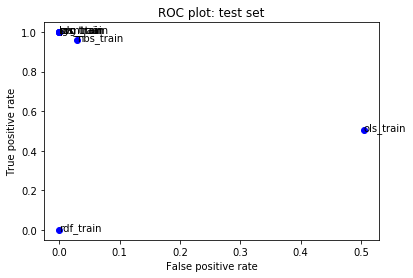

In [244]:
# ROC plot to compare performance of various models and fits

fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
# fits = [ svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, .2, 0.7, 1])
# plt.ylim(0.5, 1)
# plt.xlim(0.5,1)
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100) )
# plt.axis([0, .2, 0.7, 1])
# # plt.ylim(0.5, 1)
# # plt.xlim(0.5,1)
# plt.title('ROC plot: test set zoomed in')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [69]:
# ols_predictions = ols.predict(X_train)
# svm_predictions = svm.predict(X_train)
# lgs_predictions = lgs.predict(X_train)
# the_preds = nbs.predict(X_train)
# prc_predictions = prc.predict(X_train)
rdg_predictions = rdg.predict(X_train)

In [245]:
# let's look at some false positives:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
122
A statement of fact is not a personal attack62.252.234.27
* * * * * * * * * 
334
note to self: harassment, acknowledged trespassing.  -
* * * * * * * * * 
913
Then what business you have giving me warnings like that on my talk page? -
* * * * * * * * * 
2161
|decline=Don't be a bellend —
* * * * * * * * * 
2215
"

 Message on my talk page 

Why'd you leave me that message? I don't even know you.   "
* * * * * * * * * 
2609
... For an April Fool's joke ... ~~~~
* * * * * * * * * 
2803
"

 The Naked Brothers Band: The Movie 

I will be glad to look at it again, but it will take me a few a days. DO you want the comments on the talk page?   ><>°° "
* * * * * * * * * 
3114
I have the right to free speach.
* * * * * * * * * 
3259
Oh my god, some genres on pages don't have sources. I've seen it w/ my own 2 eyes. Have u?
* * * * * * * * * 
3317
"No doubt that Peruvian woman is far worse off; the only difference is that the photographer got her to say ""cheese""

17338
", 31 May 2009 (UTC)

Do it. The person you made the remark to took it the same as me. Learn to behave yourself or you may find yourself unable to edit. vecia 20:51"
* * * * * * * * * 
17417
This has to be one of the most unprofessional companies I've ever seen. Their commercials make the company look like a huge joke. Who would buy insurance from these people?
* * * * * * * * * 
17642
Thank you Betacommand. Much obliged.
* * * * * * * * * 
17748
Did you poop in your pants? —
* * * * * * * * * 
17778
"
Um, is there any consensus for this? The abuse filter is a very dangerous tool which I wouldn't trust many admins to use, where's the discussion for giving this right to a non admin? Chris "
* * * * * * * * * 
18208
How come it says in the block log ive been unblocked yet it doesnt show up on the talk page ?  How long does it usually take to get through?
* * * * * * * * * 
18329
ROOM MATE IS IMMATURE AND I WILL CREATE A ACCOUNT
* * * * * * * * * 
18485
Actually you know what, I'm n

27730
Congrats! I'm sure you'll do a fine job.
* * * * * * * * * 
28041
"and exactly which one of those was not appropriate to link to ""dubya""? -steve

"
* * * * * * * * * 
28152
She threatened me.  Alison, your logic is flawed.  Oprah and I have no common edits so that's reason for unblock.  If I were so technically cunning, I would not need to beg for unblock.
* * * * * * * * * 
28267
hey mind your own buisness mr.terminator.I am not uploading any copyrighted material.What;s the harm in writing an article for kids and people about something that they all massively like.Mind your own business.The wikipedia employees have the right to decide.not you
* * * * * * * * * 
28394
Pronunciation? 

142.204.141.222
* * * * * * * * * 
28553
scrap that, it does meet criteria and its gone to deletion review  contribs/talk
* * * * * * * * * 
28652
It was a porn link.
* * * * * * * * * 
28991
burch procedure 

both the burch and sling procedure deserve their own articles.
* * * * * * * * * 
29040


46390
"
Harassment? Kafziel, you are just not serious. I have not intention discussing this with you, until you can fill out a block form without tripping over yourself..Wolfowitz "
* * * * * * * * * 
46521
Ya I'll give you a source - everyone that knows her.
* * * * * * * * * 
46736
No problem I;m still licking my wounds from my last encounter so when I saw what you were doing I though I would shield you from friendly fire.
* * * * * * * * * 
46762
:Category:Allegedly anti-Semitic people
They can't delete the Category:Anti-Semitic people so they are trying another tactic !

Your vote is requested:
* * * * * * * * * 
46812
"

 ""The Gang Gets Raped""? 

An episode with this title is mentioned in the article, but not in the list of episodes. What's this about? 88.74.30.215  "
* * * * * * * * * 
47013
Big problem 
The article does not mention why and how these creatures got extinct! It just says that last one of them died of hunger!
* * * * * * * * * 
47049
Jesus Christ, some of those we

67096
ALSO, you have allowed an ERRONEOUS link to stand, even though yu have been told, repeatedly, that it is false!  The listed performer, Helen Hughes is OBVIOUSLY an ACTOR, not a PROFESSOR.
Why have you not had this corrected, you blithering TWERP?!
* * * * * * * * * 
67136
"

 Paul LePage 
Stop messaging me, as I really do not care what you think. -Thanks.  —Preceding unsigned comment added by 74.75.133.222   "
* * * * * * * * * 
67826
"|decline=I'm going to go ahead and decline your request and protect this page to prevent any further waste of time, both yours and ours. Good day.   "
* * * * * * * * * 
67954
Okay, thanks for the heads-up. Let's hope that this *expletive* is over soon... ––I hear voices in my head...
* * * * * * * * * 
68060
Oh boy.  Edits(that people don't like) are called vandelism.  Valid source are not 'decent' sources.  BS sources are valid sources(because they were provided by an editor, even if they proved nothing).  Telling the truth is telling a lie.  Cal

86290
"

I didn't call anyone for ""zionist terrorist"" STOP this fabrication!! I am the person who are most suited to edit Wikipedia instead of those liars."
* * * * * * * * * 
86881
"
How come i can still post then. Jack In "
* * * * * * * * * 
88060
Charlie is a Michael Jackson wanna be!
* * * * * * * * * 
88131
"
Also, please read Username policy and consider changing your username. Thank you, Bisswajit "
* * * * * * * * * 
89397
":No, what I'm telling you is that you're the one who's posting false statements on Wikipedia, and that if you don't stop it, you're going to be blocked.  I tire of your petulance.  talk 

"
* * * * * * * * * 
89421
not know even the abc of the Kamboj history. However, they want to be its self appointed judges and arbitrators.
* * * * * * * * * 
89553
i have no life as you can tell and never gone out with a female in my life. no joke NEVER!
* * * * * * * * * 
89600
(The bot beat me to the signature - sorry! -  | Talk
* * * * * * * * * 
89627
CIA Are Going 

103243
My goodness you do seem to have made a career out of taking issue with people and arguing out points then playing blocks. It all seems very inconsistent. Who guards the guards?
* * * * * * * * * 
103246
Its a good thing to masterbate
* * * * * * * * * 
103602
The references you provided does not substantiate. Here is a newer report which shows sri lanka armed forces good ethical conduct during operation to degrade the combat effectiveness of the Tamil tigers.  http://www.defence.lk/news/20110801_Conf.pdf
* * * * * * * * * 
103783
get me pregnant again.''
* * * * * * * * * 
104807
"

When will you learn? It's ""you're"".  "
* * * * * * * * * 
105241
No it won't. It will improve the Spongebob Squarepants article a lot. I think that this article should be in the Spongebob Squarepants article. (  )
* * * * * * * * * 
105272
Who's that girl? 

Is anyone else seeing a semi-nude woman where the graphic of Cartman as Pope should be?
* * * * * * * * * 
105569
You Can't Win 
You are fight

119798
"

 I personally have noticed something at wikipedia and in the discussion, which I would rather call ""british historical revisionism"". I'm sorry, but many Britons try to spin and squeeze facts and truthes. Additionally, they base their argumentation on statements like ""everyone knows German sources aren't reliable"" etc. and just quote British sources in contrast. British sources have been proven to be wrong and propagandistic before, too - but somehow this doesn't matter to those ""unbiased"" historians. Thus things like bombing German civilians, which was also described as crime by the British prime minister of that time and which can be called genocide if you refer to what ""Bomber Harris"" said, is being justified like ""it is okay to kill civilians with bombs, but it is a war crime if you do so with a gun"" by recent British revisionists historians. The job of many British historians seems to be to ""improve"" Britain's image by any mean.
  "
* * * * * * * * * 
120016
W

In [246]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(the_preds)):
    if (the_preds[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
#             if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false negatives:
346
stupid bots deleting pics

I would like to ask a HUMAN to review the entry, and possibly add photos from the links I have provided. I cannot figure out how to do it myself.

Also, someone should either reprogram or shut down this BOT.

April 2008
 Welcome to Wikipedia. Although everyone is welcome to contribute constructively to the encyclopedia, one or more of the external links you added  do not comply with our guidelines for external links and have been removed. Wikipedia is not a collection of links; nor should it be used for advertising or promotion. Since Wikipedia uses nofollow tags, external links do not alter search engine rankings. If you feel the link should be added to the article, please discuss it on the  before reinserting it. Please take a look at the welcome page to learn more about contributing to this encyclopedia. 

Your edit here was reverted by an automated bot that attempts to remove unwanted links and spam from Wikipedia. If you 

7653
It isn't 1998 

Stop using the font element, you fool.
* * * * * * * * * 
8475
WHY DID YOU EDIT THE ARTICLE ON KURDISTAN? 

DID YOU READ THIS DISCUSSIONS BEFORE YOU MADE THE CHANGES? 

They are adding silly things to the article.
* * * * * * * * * 
8695
"

Macedonian point of view
Why there is not the Macedonian point of view and where is the bloody division of Macedonia and where is the paragraph about the occupation of the Macedonian parts? So pathetic.  Oui? "
* * * * * * * * * 
8928
"

 You are a bit of an idiot, aren´t you? 

 As per you: ""Delete recently created article that duplicates an existing topic, inflation""

Please indicate where the term Inflation myths appear on the Inflation target. 

Idiot!!

  "
* * * * * * * * * 
9361
WITHOUT consensus? Who the fuck do you think you are? I have to ask for permission to add a useful comment in the body of an article? This sounds like discrimination against a specific individual and makes absolutely no sense. Now fuck off, I'll

17866
MY CHANGES DO NOT AFFECT ANY OF THE CONCOCTED OFFENSES YOU HAVE BROUGHT UP!

 WP:NPOV issues / synthesis
   WP:Verifiable
   WP:OR

I want to bring your OWN STANCE, as being pro orthodox which in itself is BIASED!

i am again going to put the changes back on, BECAUSE I believe your STANCE IS TO PROTECT THE CURRENT SINGH SABHA ideological stance on sikhism, WHICH MEANS that wikipedia ONLY ACCEPTS ORTHODOX POV and NOT unorthodox! Which means going by your OWN judgment, that the CHRISTIAN UNORTHODOX CHURCH, which exist, on real life and on wiki, HAS NO merit!

THAT IS A BIASED APPROACH!
* * * * * * * * * 
18693
"

 Stop your fucking spamming 

I have told you and your sock/meat puppets a dozen or more times to stop your fucking spamming. Your incessant spamming on editors pages will not help your fucking cause at all, it will merely continue to confirm editors opinions that not only is the article not valid, but there are problems with the editors that will need to be addressed as w

44872
they have poor theories
* * * * * * * * * 
44928
Re:
The idiot keeps putting G-Unit Records on Product of the South, when the reference clearly states its not going to be.
* * * * * * * * * 
45642
Your incorrect opinion, and lord knows you are certainly full of them.  But get your eyes checked so you can avoid such stupid statements in the future.
* * * * * * * * * 
45969
Categories aren't substantial content. Only a moron would think so. -
* * * * * * * * * 
48077
I CANNOT BELIEVE THIS WHAT THE #@@%K
if you continue to do this i will have to take some drastic measures watch your step it may be your last
* * * * * * * * * 
48288
What the FUCK are you doing? 

Lay off my questions.  It's bad enough you start your own sections for your own answers.  A separate question is a separate question, and I shouldn't have to go searching for it because you have taken it on yourself to move it.
* * * * * * * * * 
48596
What the hell are you talking about? 

Inserting tags on an article is no

55541
I was auto-blocked because my last username had Arabic letters. Somewhat stupid reason to block a user indefinitely....
* * * * * * * * * 
56858
You need to end this now, cold turkey.
* * * * * * * * * 
56988
Quick question 

Why do you suck so much, and what actions do you take to ensure your low quality in every respect?
* * * * * * * * * 
57631
I AM ADDING REFERENCES AND AM REMOVING THE TAGS AS I GO. SO STICK YOUR LAST WARNING!!!
* * * * * * * * * 
57869
well, you know, fuck your idea of 'notability', and fuck your line. i make this art for others and i don't ask for anything in return, so if wikipedia cannot deal with my artistic practice its most probably as corrupt as the fucking system itself. don't excuse me for my language, i make my own choices. and if i must make money to be considered notable, then fuck the world too.
* * * * * * * * * 
58062
Simply; don't delete any of my comments in the future because it violates Wikipedia's policies. I know you're trying to avoid a

70778
"

No!  This is a GROUP EFFORT!  Wikipedia is a collaborative COMMUNITY and there are no school essays here.  The article needs to be more professional and adopt a better title besides the references.  This is all that needs to be done, so get off your high horse and accomplish what you want to see done.  If you have these goals, then put yourself to the test of solving this problem.  That's what I do whenever something perturbs me.  You're just looking for a fight about something you admittedly care nothing about.  How about I come by your house and criticise your gardens?  ""Why?"" You say.  ""Because they are too fucking ugly and I don't like the way they  don't blend in with the neighbours' yards.  So tacky, but I'm only passing by and I've never been down this road before.""   15:24, 25 Feb 2005 (UTC)"
* * * * * * * * * 
72223
What difference does it make? GO AWAY. I am NOT testing, I am making edits that you decide to RV just because they're by me.
* * * * * * * * * 
72974


83544
This is your final warning if you persist in vandalism your account will be deleted and further legal action will be taken against you.
* * * * * * * * * 
83696
Hi, the Greek pages are a disgrace. The demographics section was written some time ago with correct data and many links to support them, and they have all been removed. I am not going to deal with this, because it is not my function in life to clear up the SHIT of other people. Please accept that what is written there is propaganda and lies, and needs ro be removed,. Thank you.
* * * * * * * * * 
83848
" You're a dumb American, right? No degree? Knows nothing of engineering? Thinks mathematics is ""universal""? Played monopoly in high school instead of learning? How am I doing so far?"
* * * * * * * * * 
84238
Look at your own ridiculous behavior first. By the way, I'm a different user than the one you seem to be writing to/about, even though I agree with this user more than I agree with you.
* * * * * * * * * 
85092
It w

101892
I do think that  is heavily biased and that accusations as given are baseless. My all contributions are strictly supported by valid references and claim that 'everyone has finally gotten sick of you' is generic, baseless, and offensive.
* * * * * * * * * 
102205
He's a Troll 
 several times, so I give up, except he'll remove this, more than sufficient evidence of his double-standard.
* * * * * * * * * 
102524
I just feel that it shouldn't be a fucking adjective! Is that too much to ask? There aren't ANY adjective titles in Wikipedia; they are ALL disambiguation pages. I made it into a disambiguation page, and moved it to a reasonable title, and you got an admin to delete it? Like WTF?
* * * * * * * * * 
102571
Thanks
Thanks for participating in the conspiracy against me.
* * * * * * * * * 
103400
Please do not interfere in my affair. Mind your own business . You are responsible for this .Now i am facing losses just because of what you did . So please . I don't need your help. I 

115236
Road Good aRticles are a pain in the ass. I've asked some one involved with the project what needs to be done with the article to take it to GA.  The history needs to be there, especially the early history which is missing.  It also needs more information on the road features, such as intersections, road width, road markings, etc. The few sources I've looked at haven't included this, and the roads people tend to use Google Maps as a source for the major intersections part.
* * * * * * * * * 
115631
"

 Follow policy: Don't edit others talk-page comments 

Look, David the administrator,

Don't edit others comments.

""No"" is unacceptable from any experienced editor, unless the editor feels that an administrator button is a license to behave like an asshole.

.Wolfowitz "
* * * * * * * * * 
116189
His edits do suck, which is why I reverted them over and over again.  Not one edit contributed positively to the article, and most served the needs of the Crusaders.  In any case, I've 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

In [247]:
# MODEL: ordinary least squares
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1629, 'TN': 14270, 'FP': 14443, 'FN': 1573, 'Accuracy': 0.49816700610997966, 'Precision': 0.1013563962170234, 'Recall': 0.5087445346658338, 'desc': 'ols_test'}


In [248]:
# MODEL: SVM, linear
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1565, 'TN': 27475, 'FP': 1238, 'FN': 1637, 'Accuracy': 0.9099169669434435, 'Precision': 0.5583303603282198, 'Recall': 0.4887570268582136, 'desc': 'svm_test'}


In [249]:
# MODEL: logistic regression
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1596, 'TN': 27300, 'FP': 1413, 'FN': 1606, 'Accuracy': 0.9054049819833934, 'Precision': 0.5304087736789631, 'Recall': 0.49843847595252966, 'desc': 'lgs_test'}


In [250]:
# MODEL: Naive Bayes
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1326, 'TN': 27369, 'FP': 1344, 'FN': 1876, 'Accuracy': 0.8991070029766568, 'Precision': 0.4966292134831461, 'Recall': 0.4141161773891318, 'desc': 'nbs_test'}


In [251]:
# MODEL: Perceptron
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1621, 'TN': 27378, 'FP': 1335, 'FN': 1581, 'Accuracy': 0.9086323045589848, 'Precision': 0.5483761840324763, 'Recall': 0.5062460961898814, 'desc': 'prc_test'}


In [252]:
# MODEL: Ridge Regression Classifier
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3202, 'Neg': 28713, 'TP': 1486, 'TN': 27826, 'FP': 887, 'FN': 1716, 'Accuracy': 0.918439605201316, 'Precision': 0.6262115465655289, 'Recall': 0.46408494690818236, 'desc': 'rdg_test'}


In [253]:
# MODEL: Random Forest Classifier
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

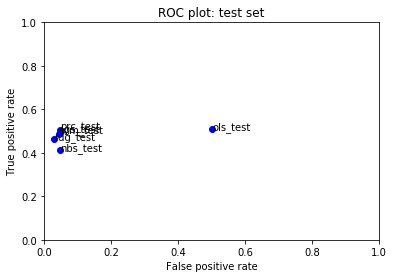

In [254]:
# ROC plot to compare performance of various models and fits

# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svm_performance_test,  nbs_performance_test,  rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
plt.axis([0, 1, 0, 1])
# plt.axis([0, 0.3, 0.5, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc +': '+str(round(fit.performance_measures['FP'] / fit.performance_measures['Neg']*100)/100) +','+ str(round(fit.performance_measures['TP'] / fit.performance_measures['Pos']*100)/100) )
    
# # plt.axis([0, 1, 0, 1])
# plt.axis([0, 0.3, 0.4, 1])
# plt.title('ROC plot: test set zoomed in')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [255]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../final_data/toxiccomments_test.csv', my_random_seed=33, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [256]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# my_submission["prediction"] = ols.predict(X_test_submission)
# my_submission["prediction"] = svm.predict(X_test_submission)
# my_submission["prediction"] = lgs.predict(X_test_submission)
# my_submission["prediction"] = prc.predict(X_test_submission)
my_submission["prediction"] = rdg.predict(X_test_submission)

# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.13166279282337887


In [257]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [258]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [259]:
my_submission.shape

(153164, 2)

In [260]:
# export submission file as pdf
# CHANGE FILE PATH: 
# my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)
my_submission.to_csv('../final_data/toxiccomments_submission_draft1.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation